# Question 4: Production Trends and Future Outlook

## Connect to the database and pull required tables

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sqlalchemy import create_engine
from matplotlib.lines import Line2D

DB_USER = "mfre521d_user"
DB_PASSWORD = "mfre521d_user_pw"
DB_HOST = "127.0.0.1"
DB_PORT = "3306"
DB_NAME = "mfre521d"

engine = create_engine(f"mysql+pymysql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}")

CROPS = ["Wheat", "Rice", "Maize"]
PROJECTION_YEARS = 10

START_YEAR = None

CLIMATE_VARS = ["extreme_hot_days", "annual_precip_total", "annual_gdd"]

# load the integrated table
query = """
SELECT
  country, iso_code, year, region, income_group, crop,
  area_harvested_ha, production_tonnes, yield_kg_ha,
  avg_temp_weather, avg_min_temp, avg_max_temp,
  avg_precipitation, avg_rain, avg_transp,
  annual_gdd, annual_precip_total, daily_precip_sd,
  extreme_hot_days, extreme_cold_days, extreme_temp_days
FROM integrated_crop_weather
WHERE crop IN ('Wheat','Rice','Maize');
"""
df = pd.read_sql(query, engine)

df["year"] = df["year"].astype(int)
df["region"] = df["region"].fillna("Unknown")
df["income_group"] = df["income_group"].fillna("Unknown")

if START_YEAR is not None:
    df = df[df["year"] >= START_YEAR].copy()

print(df.shape)
df.head()

(753, 21)


,country,iso_code,year,region,income_group,crop,area_harvested_ha,production_tonnes,yield_kg_ha,avg_temp_weather,...,avg_max_temp,avg_precipitation,avg_rain,avg_transp,annual_gdd,annual_precip_total,daily_precip_sd,extreme_hot_days,extreme_cold_days,extreme_temp_days
0,United States,USA,2018,North America,High income,Wheat,4782989,32397951.41,6773.58,11.5814,...,17.3142,2.3608,2.1082,3.3427,695.10,861.7,6.0340,65,132,197
1,United States,USA,2022,North America,High income,Wheat,1520076,15199442.37,9999.13,12.3499,...,18.5101,1.2721,1.1526,4.0006,925.05,464.3,4.1398,80,130,210
2,Nigeria,NGA,2016,Sub-Saharan Africa,Lower middle income,Wheat,200578,882142.37,4398.00,25.9268,...,31.1082,6.0454,6.0454,4.3836,5977.60,2212.6,10.6937,211,0,211
3,India,IND,2021,South Asia,Lower middle income,Rice,4362406,30497138.80,6990.90,27.1490,...,32.5912,3.0644,3.0644,4.6325,6363.05,1118.5,7.6058,272,0,272
4,Nigeria,NGA,2021,Sub-Saharan Africa,Lower middle income,Wheat,1086889,6054085.19,5570.10,25.7181,...,30.8195,3.6299,3.6299,4.6150,5891.85,1324.9,8.8190,227,0,227


## Helper function

This chunk defines the helper function that fits a simple linear time trend to each series and then extends it forward for a 10-year projection. I use this function across production, yield, and harvested area so every region/crop is treated the same.

In [2]:
def fit_trend_and_project(year, y, proj_years=10):
    """
    Fits y = a + b*year using numpy.polyfit
    Returns observed years + fitted trend, and projected years + dashed projection
    """
    tmp = pd.DataFrame({"year": year, "y": y}).dropna()
    if tmp["year"].nunique() < 5:
        return None

    # yearly mean
    grp = tmp.groupby("year")["y"].mean().reset_index()

    x = grp["year"].values
    y = grp["y"].values

    # linear trend
    b, a = np.polyfit(x, y, 1)

    # observed fit
    yhat_obs = a + b * x

    # projection
    last_year = x.max()
    x_proj = np.arange(last_year + 1, last_year + proj_years + 1)
    yhat_proj = a + b * x_proj

    return x, y, yhat_obs, x_proj, yhat_proj

## Part 1: Global and regional production, yiled, and area harvested: trends and projections

This chunk defines the main plotting function for Part 1 that aggregates the data to the geographic level (global, regional, income group) and produces a three-panel graph for production, yield, and harvested area. The function overlays observed points, the fitted trend, and the dashed 10-year projection so the long-run pattern and outlook are simultaneously visible.

In [3]:
def plot_part1_for_geo(df_geo, geo_label):
    import numpy as np
    from matplotlib.lines import Line2D
    from matplotlib.ticker import FuncFormatter, MaxNLocator

    g = (df_geo
         .groupby(["year", "crop"], as_index=False)
         .agg(production_tonnes=("production_tonnes", "sum"),
              area_harvested_ha=("area_harvested_ha", "sum"),
              yield_kg_ha=("yield_kg_ha", "mean")))

    metrics = [
        ("production_tonnes", "Production (tonnes)"),
        ("yield_kg_ha", "Yield (kg/ha)"),
        ("area_harvested_ha", "Harvested Area (ha)")
    ]

    crop_colors = {
        "Wheat": "#1f77b4",
        "Rice":  "#2ca02c",
        "Maize": "#d62728"
    }

    fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=True)
    fig.suptitle(f"Long-run trends + {PROJECTION_YEARS}-year projection — {geo_label}", fontsize=14)

    # helper to scale large numbers
    def get_scale_and_label(values):
        max_val = np.nanmax(np.abs(values))
        if max_val >= 1e9:
            return 1e9, "billions"
        elif max_val >= 1e6:
            return 1e6, "millions"
        elif max_val >= 1e3:
            return 1e3, "thousands"
        else:
            return 1, ""

    for ax, (col, ttl) in zip(axes, metrics):

        # determine scaling
        if col in ["production_tonnes", "area_harvested_ha"]:
            scale, magnitude = get_scale_and_label(g[col].values)
        else:
            scale, magnitude = 1, ""

        for crop in CROPS:
            sub = g[g["crop"] == crop].sort_values("year")
            color = crop_colors.get(crop, "black")

            fit = fit_trend_and_project(sub["year"], sub[col], proj_years=PROJECTION_YEARS)
            if fit is None:
                continue

            yrs_obs, y_obs, yhat_obs, yrs_proj, yhat_proj = fit

            # scale values
            y_obs = y_obs / scale
            yhat_obs = yhat_obs / scale
            yhat_proj = yhat_proj / scale

            ax.scatter(yrs_obs, y_obs, s=18, color=color)
            ax.plot(yrs_obs, yhat_obs, linewidth=2, color=color)
            ax.plot(yrs_proj, yhat_proj, linewidth=2, linestyle="--", color=color)

        # titles
        if magnitude != "":
            ax.set_title(f"{ttl.split('(')[0].strip()} ({ttl.split('(')[1].split(')')[0]}, {magnitude})")
        else:
            ax.set_title(ttl)

        ax.set_xlabel("Year")
        ax.grid(True, alpha=0.3)

        ax.xaxis.set_major_locator(MaxNLocator(integer=True))

        ax.ticklabel_format(style='plain', axis='y')

    axes[0].set_ylabel("Value")

    # create legend
    legend_handles = []

    for crop in CROPS:
        color = crop_colors.get(crop, "black")

        legend_handles.append(
            Line2D([0], [0], marker='o', linestyle='None',
                   color=color, markersize=6,
                   label=f"{crop} observed")
        )

        legend_handles.append(
            Line2D([0], [0], linestyle='-',
                   color=color, linewidth=2,
                   label=f"{crop} trend")
        )

        legend_handles.append(
            Line2D([0], [0], linestyle='--',
                   color=color, linewidth=2,
                   label=f"{crop} projection")
        )

    fig.legend(
        handles=legend_handles,
        loc="center left",
        bbox_to_anchor=(1.02, 0.5),
        frameon=False,
        ncol=1
    )

    plt.tight_layout(rect=[0, 0, 1, 1])
    plt.show()

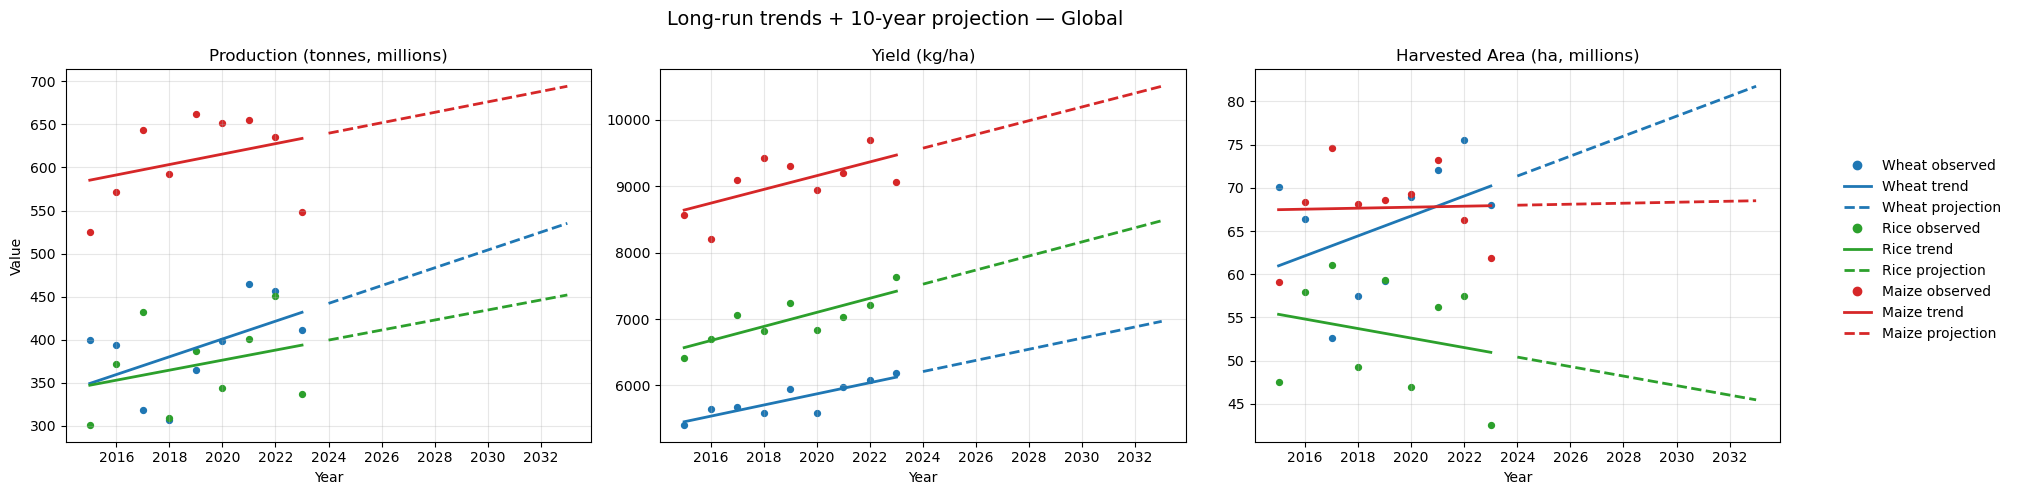

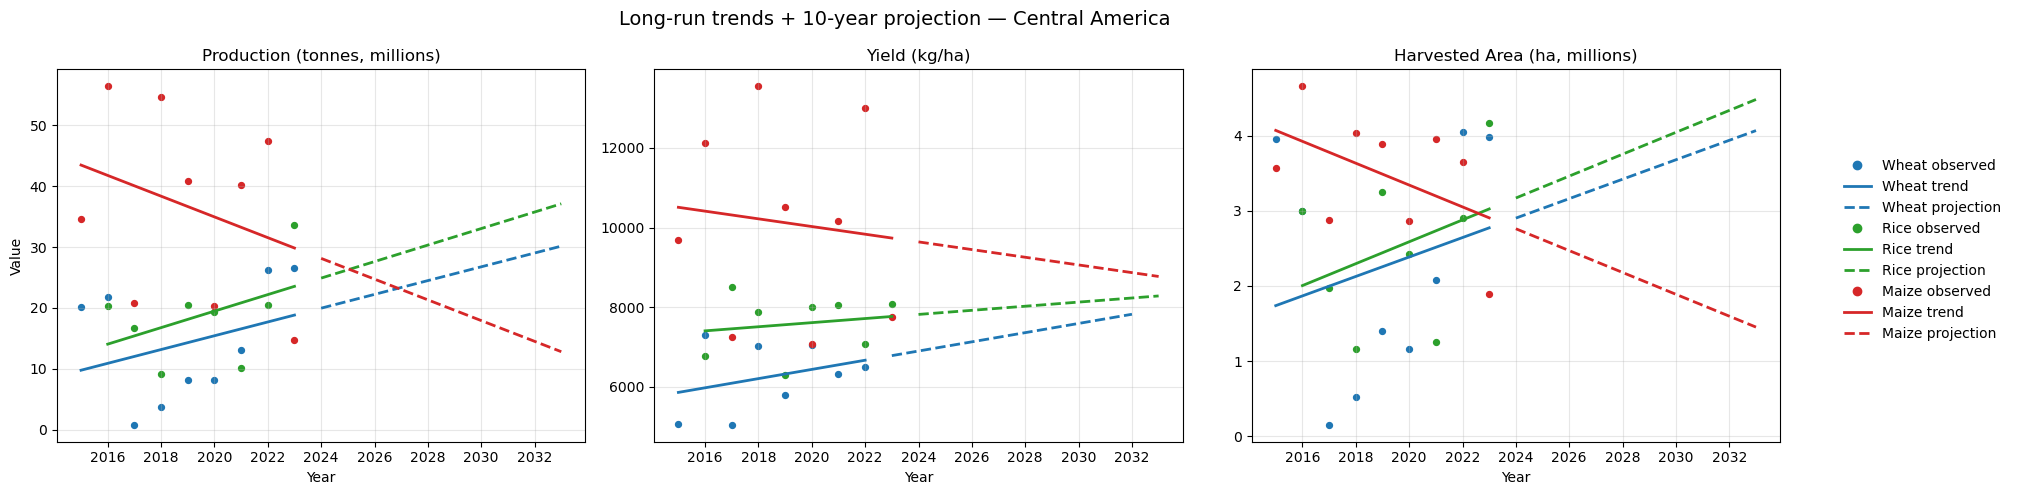

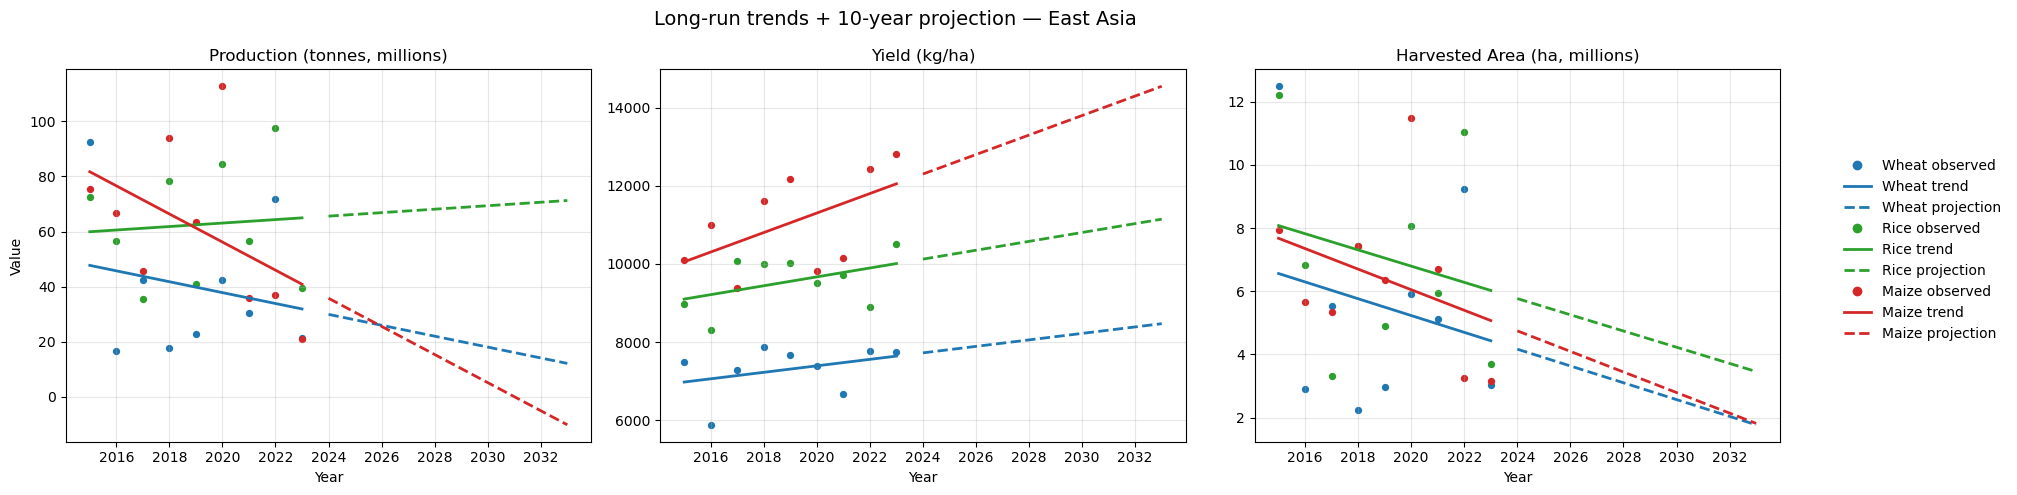

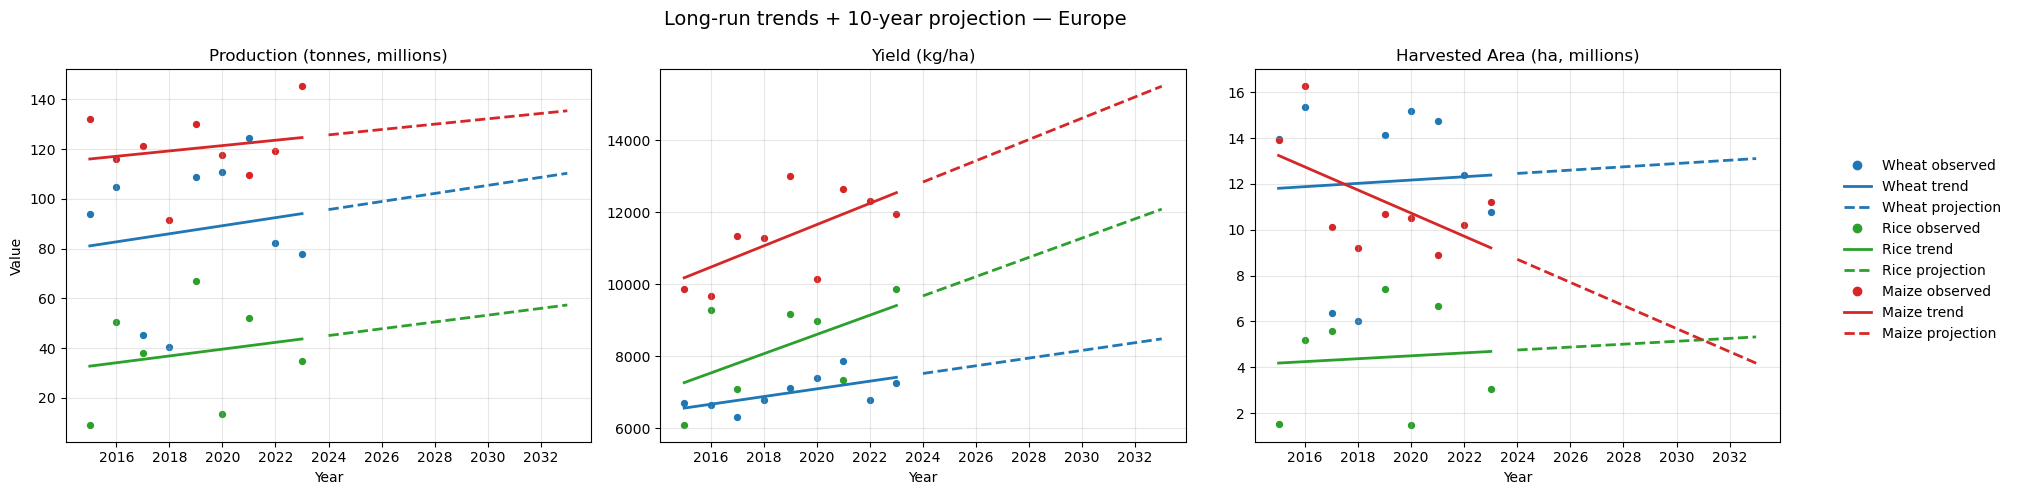

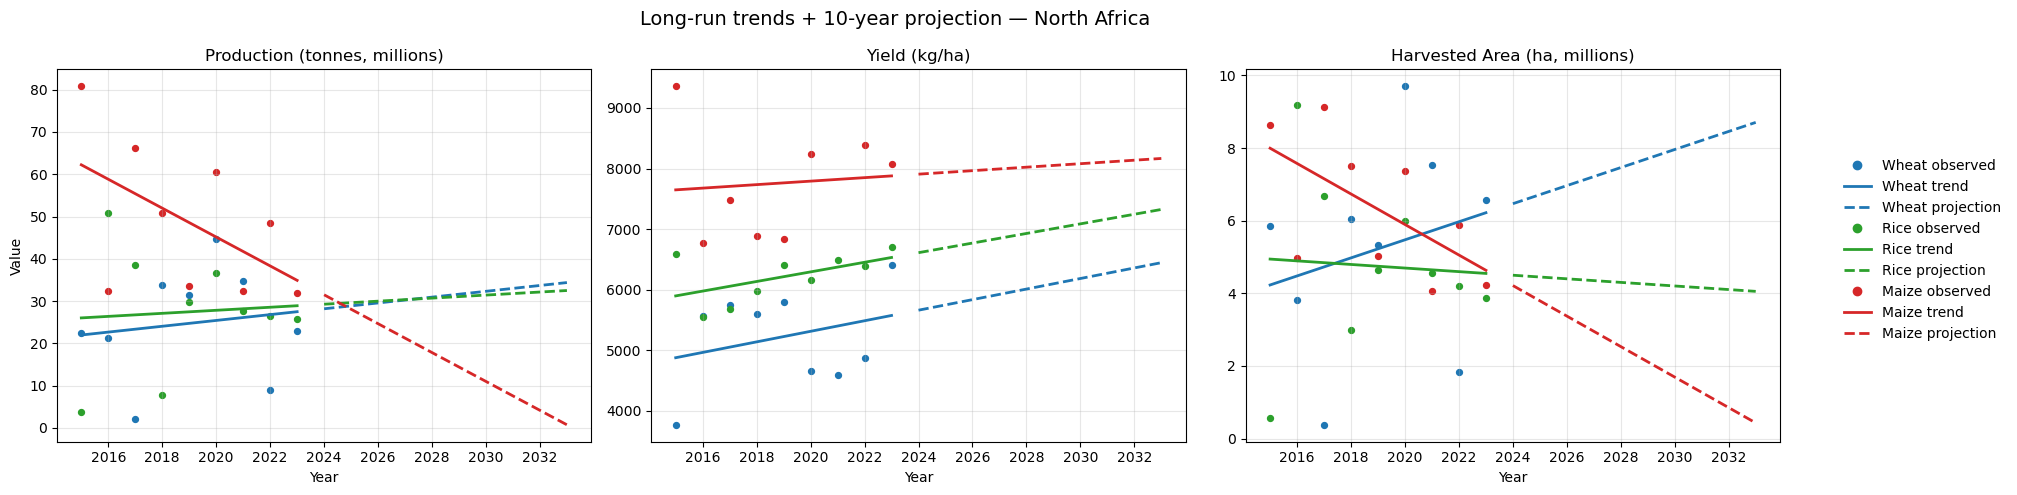

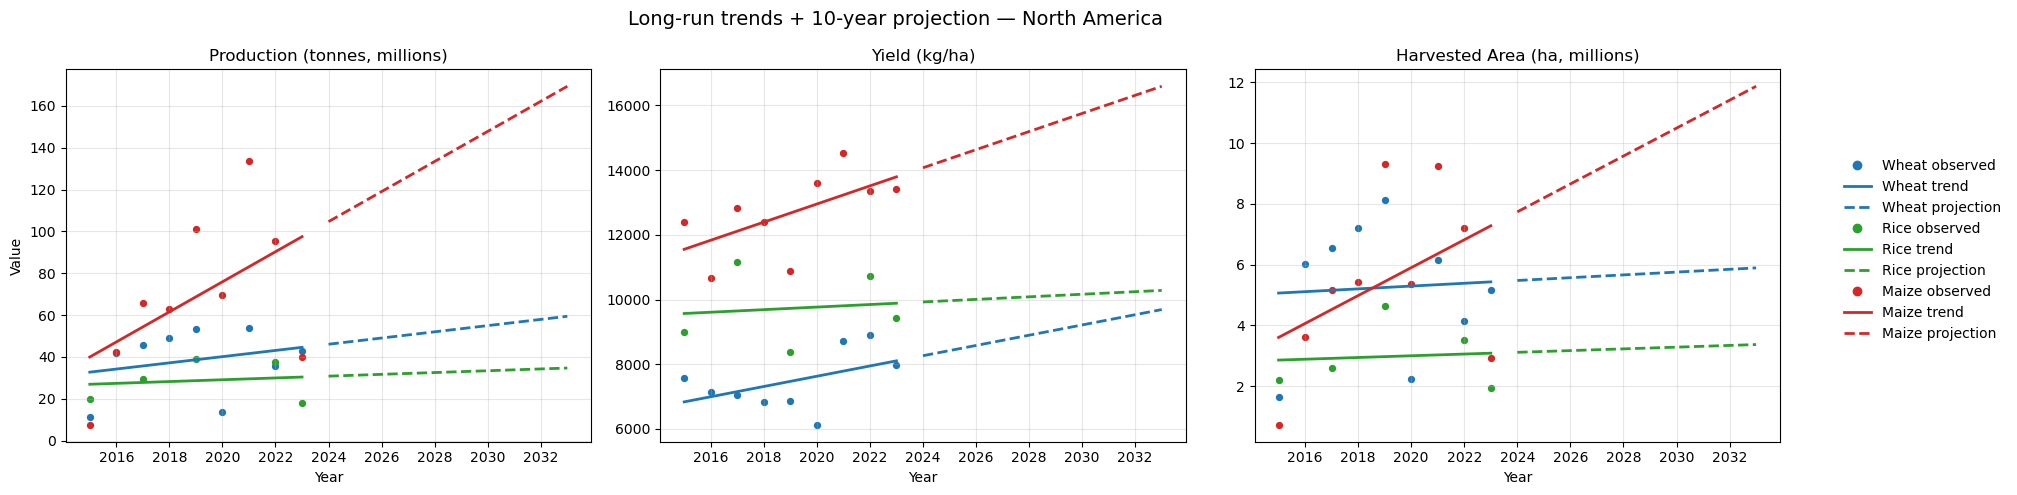

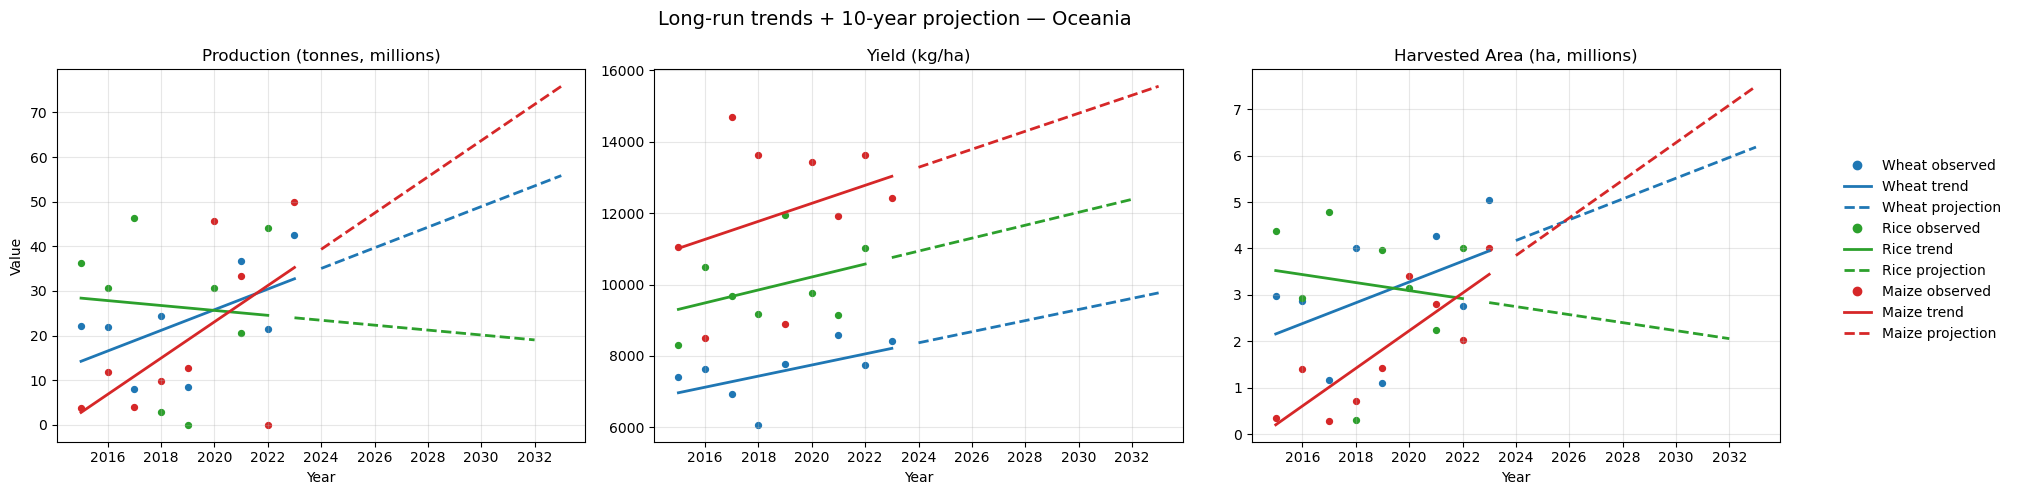

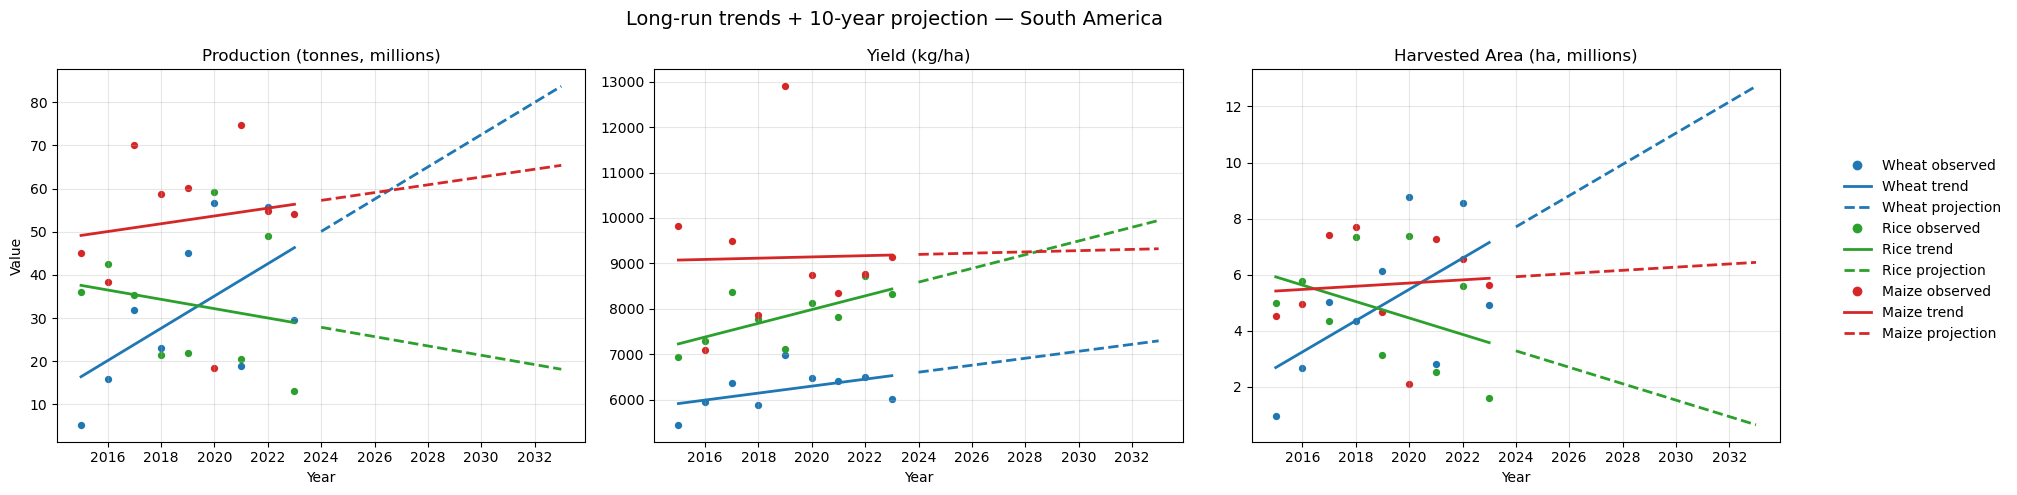

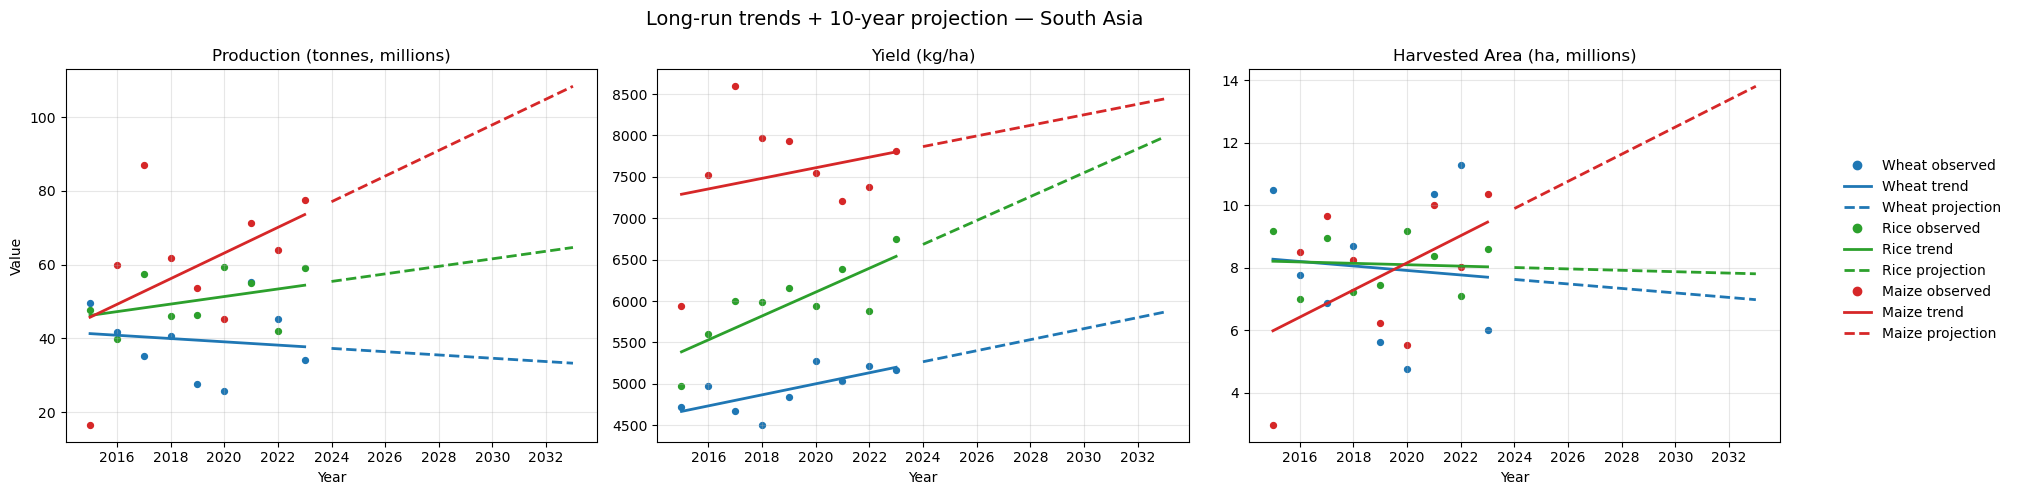

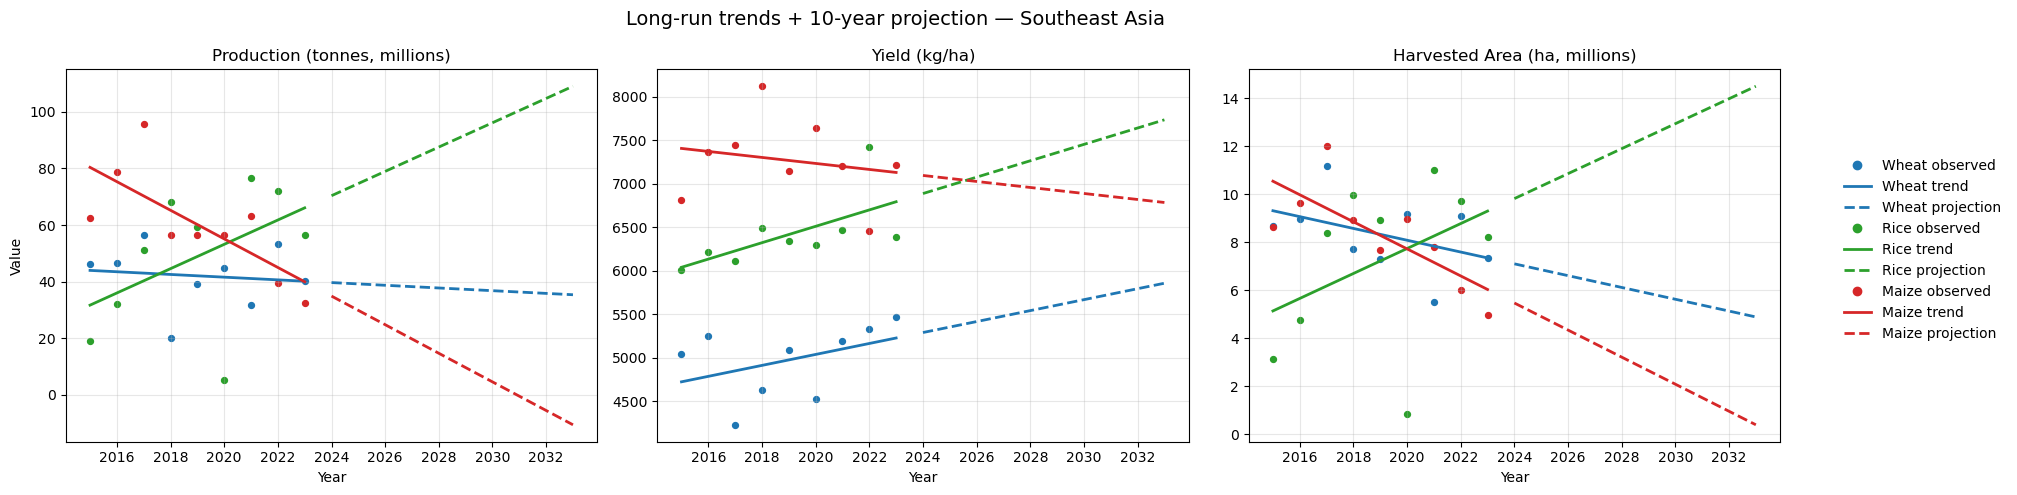

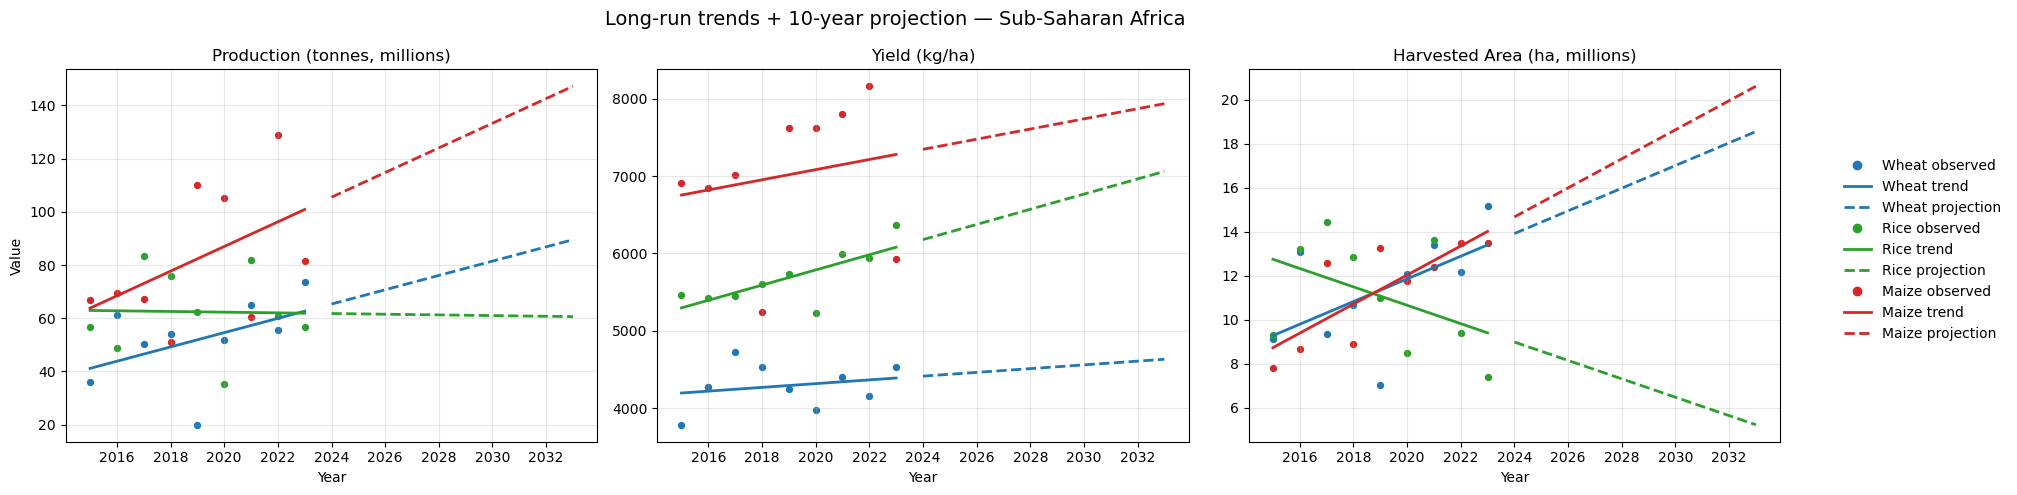

In [4]:
# plot global trends
plot_part1_for_geo(df, "Global")

# plot regions trends
for r in sorted(df["region"].unique()):
    plot_part1_for_geo(df[df["region"] == r], r)

## Part 2: Decompose yield changes into climate vs tech/inputs vs area expansion

This chunk sets the parameters for the decomposition and enforce the required column checks up front. This acts as a guardrail so Part 2 flags if the dataset is missing key values.

In [5]:
CROPS = ["Wheat", "Rice", "Maize"]
PROJECTION_YEARS = 10

# assign climate variable of interest
CLIMATE_VARS = ["extreme_hot_days"]

# required columns
needed = {"region", "crop", "year", "yield_kg_ha", "area_harvested_ha"}
missing = needed - set(df.columns)
if missing:
    raise ValueError(f"df is missing required columns: {missing}")

# ensure the chosen climate variable exists
missing_clim = [v for v in CLIMATE_VARS if v not in df.columns]
if missing_clim:
    raise ValueError(f"Missing climate column(s) in df: {missing_clim}")

print("Using climate vars:", CLIMATE_VARS)

Using climate vars: ['extreme_hot_days']


This chunk collapses the raw data into a clean region x crop x year panel and computes the components needed for the decomposition. This section of Part 2 turns the dataset into a format where climate vc technology/inputs vs area expansion can be compared consistently across regions.

In [6]:
def build_region_year_panel(df_in, climate_var="extreme_hot_days"):
    """
    Collapse to region × crop × year so climate coverage becomes usable.
    """
    panel = (df_in
             .groupby(["region", "crop", "year"], as_index=False)
             .agg(
                 yield_kg_ha=("yield_kg_ha", "mean"),
                 area_harvested_ha=("area_harvested_ha", "sum"),
                 climate=(climate_var, "mean")
             ))
    return panel

def build_decomposition_region_panel(panel):
    rows = []
    for (region, crop), g in panel.groupby(["region", "crop"]):
        g = g.sort_values("year")

        # keep only years where all needed vars exist and are positive
        d = g.dropna(subset=["yield_kg_ha", "area_harvested_ha", "climate"]).copy()
        d = d[(d["yield_kg_ha"] > 0) & (d["area_harvested_ha"] > 0)]
        if d["year"].nunique() < 8:
            continue

        # regression: ln(yield) = a + b*climate + c*year
        y = np.log(d["yield_kg_ha"].values)
        X = np.column_stack([
            np.ones(len(d)),
            d["climate"].values,
            d["year"].values
        ])
        beta, *_ = np.linalg.lstsq(X, y, rcond=None)
        b_clim = beta[1]
        b_year = beta[2]

        # start/end from usable data
        y0, yT = d["yield_kg_ha"].iloc[0], d["yield_kg_ha"].iloc[-1]
        a0, aT = d["area_harvested_ha"].iloc[0], d["area_harvested_ha"].iloc[-1]
        c0, cT = d["climate"].iloc[0], d["climate"].iloc[-1]
        t0, tT = int(d["year"].iloc[0]), int(d["year"].iloc[-1])

        dln_yield = np.log(yT) - np.log(y0)
        dln_area  = np.log(aT) - np.log(a0)

        dln_climate = b_clim * (cT - c0)
        dln_tech    = b_year * (tT - t0)

        # yield slope (stagnation/decline check)
        slope = np.polyfit(d["year"].values, d["yield_kg_ha"].values, 1)[0]

        rows.append({
            "region": region,
            "crop": crop,
            "year_start": t0,
            "year_end": tT,
            "yield_slope": float(slope),
            "climate_pct": 100 * float(dln_climate),
            "tech_inputs_pct": 100 * float(dln_tech),
            "area_pct": 100 * float(dln_area),
            "n_years_used": int(d["year"].nunique())
        })

    return pd.DataFrame(rows)

CLIMATE_VAR = "extreme_hot_days"

panel = build_region_year_panel(df, climate_var=CLIMATE_VAR)
dec = build_decomposition_region_panel(panel)

print("Decomposition rows:", dec.shape[0])
dec.head()


Decomposition rows: 28


,region,crop,year_start,year_end,yield_slope,climate_pct,tech_inputs_pct,area_pct,n_years_used
0,Central America,Maize,2015,2023,-96.562167,-59.928847,38.425339,-63.215555,9
1,Central America,Rice,2016,2023,51.630119,-6.281495,9.649465,32.662113,8
2,Central America,Wheat,2015,2022,115.532976,-13.790787,26.191300,2.153512,8
3,East Asia,Maize,2015,2023,249.783389,-0.365016,22.011636,-91.958865,9
4,East Asia,Rice,2015,2023,113.720667,0.608348,6.504984,-119.154828,9


In [7]:
# export decomposition data
output_path = "q4_production_decomposition_region_crop.csv"

dec.to_csv(output_path, index=False)

print(f"Q4 decomposition data exported to: {output_path}")

Q4 decomposition data exported to: q4_production_decomposition_region_crop.csv


This chunk takes the decomposition output and plots the contributions of climate, technology/inputs, and area expansion by region for each crop. The goal here is interpretability: it makes it immediately clear whether growth is eing driven by yield improvements, land expansion, or whether climate stress is acting as a hinderance.

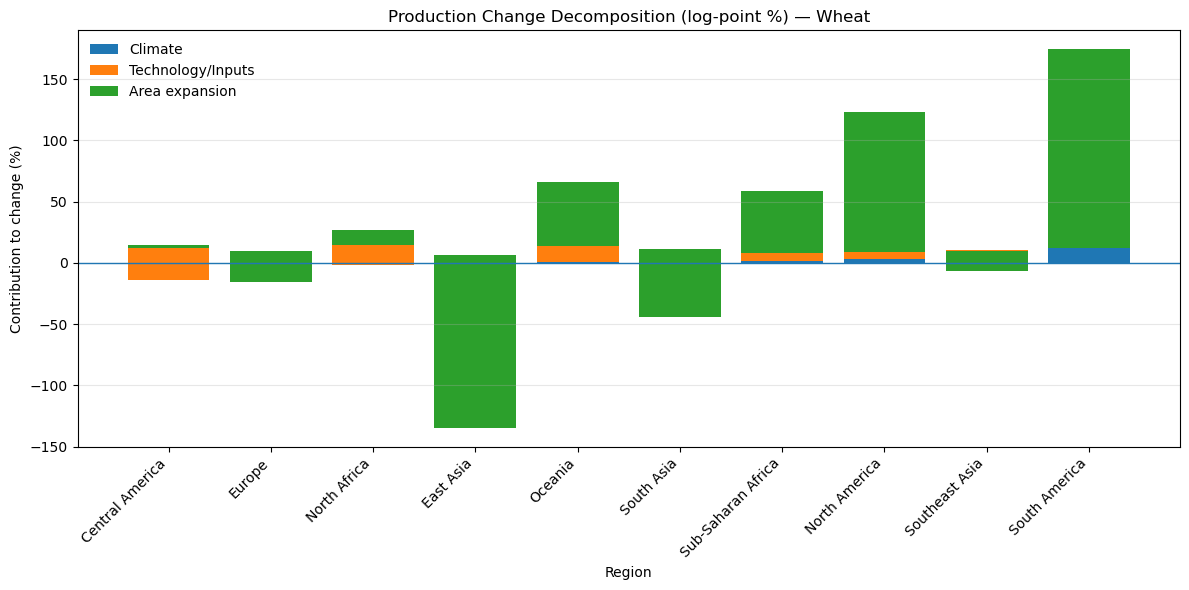

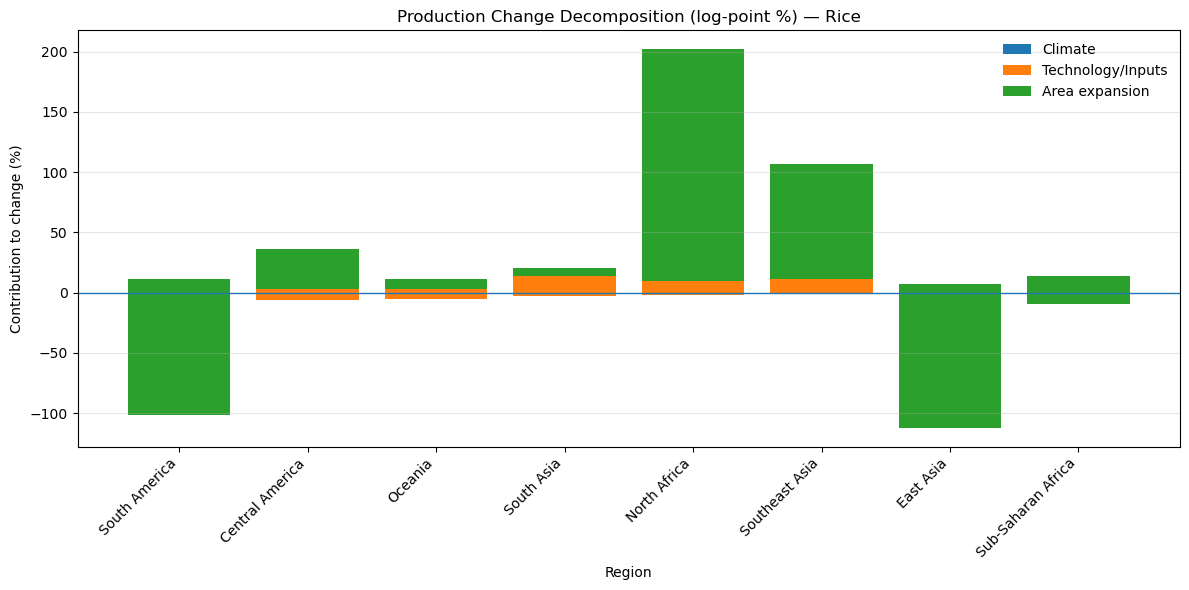

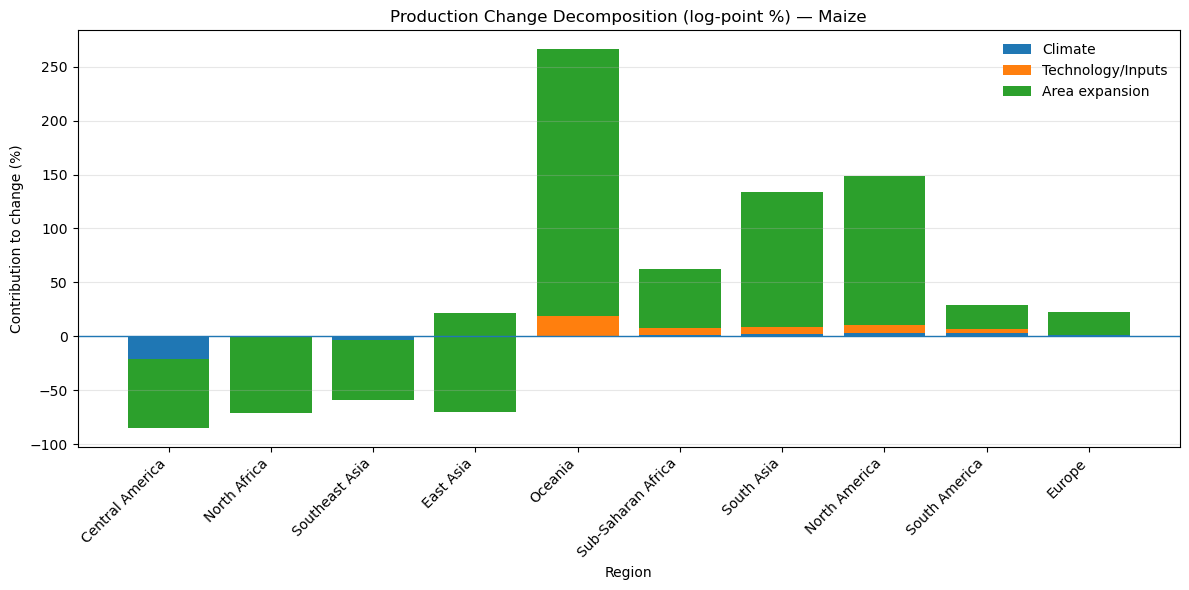

In [8]:
def plot_decomp_crop(dec_df, crop_name):
    d = dec_df[dec_df["crop"] == crop_name].copy()
    if d.empty:
        print(f"No data to plot for {crop_name}")
        return

    d = d.sort_values("climate_pct")
    regions = d["region"].tolist()

    fig, ax = plt.subplots(figsize=(12, 6))
    bottom = np.zeros(len(d))

    for col, label in [
        ("climate_pct", "Climate"),
        ("tech_inputs_pct", "Technology/Inputs"),
        ("area_pct", "Area expansion")
    ]:
        ax.bar(regions, d[col].values, bottom=bottom, label=label)
        bottom += d[col].values

    ax.axhline(0, linewidth=1)
    ax.set_title(f"Production Change Decomposition (log-point %) — {crop_name}")
    ax.set_ylabel("Contribution to change (%)")
    ax.set_xlabel("Region")
    ax.legend(frameon=False)
    ax.grid(True, axis="y", alpha=0.3)
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

for crop in CROPS:
    plot_decomp_crop(dec, crop)

This chunk creates a small diagnostic table that flags region-crop pairs where yields are flat/declining anf the estimated climate contribution is negative over the period of 2015-2023. This provides a concise list of places where climate stress, in this case extreme heat days, is plausibly already weighing on yield trends. This quanitfies the trends see visually in Part 1.

In [9]:
climate_affected = (dec
    .loc[(dec["yield_slope"] <= 0) & (dec["climate_pct"] < 0),
         ["crop", "region", "year_start", "year_end", "yield_slope", "climate_pct", "tech_inputs_pct", "area_pct"]]
    .sort_values(["crop", "climate_pct"])
    .reset_index(drop=True)
)

climate_affected

,crop,region,year_start,year_end,yield_slope,climate_pct,tech_inputs_pct,area_pct
0,Maize,Central America,2015,2023,-96.562167,-59.928847,38.425339,-63.215555
1,Maize,Southeast Asia,2015,2023,-34.483542,-3.985785,0.314897,-55.000772


## Part 3 (Extension): Repeat Part 1 by development stage (income_group)

This chunk applies the same logic as the trend and projecting workflow in Part 1, but groups by income category instead of geography. This allows for comparison of whether production growth is coming from yield gains or area expansion at different stages of economic development.

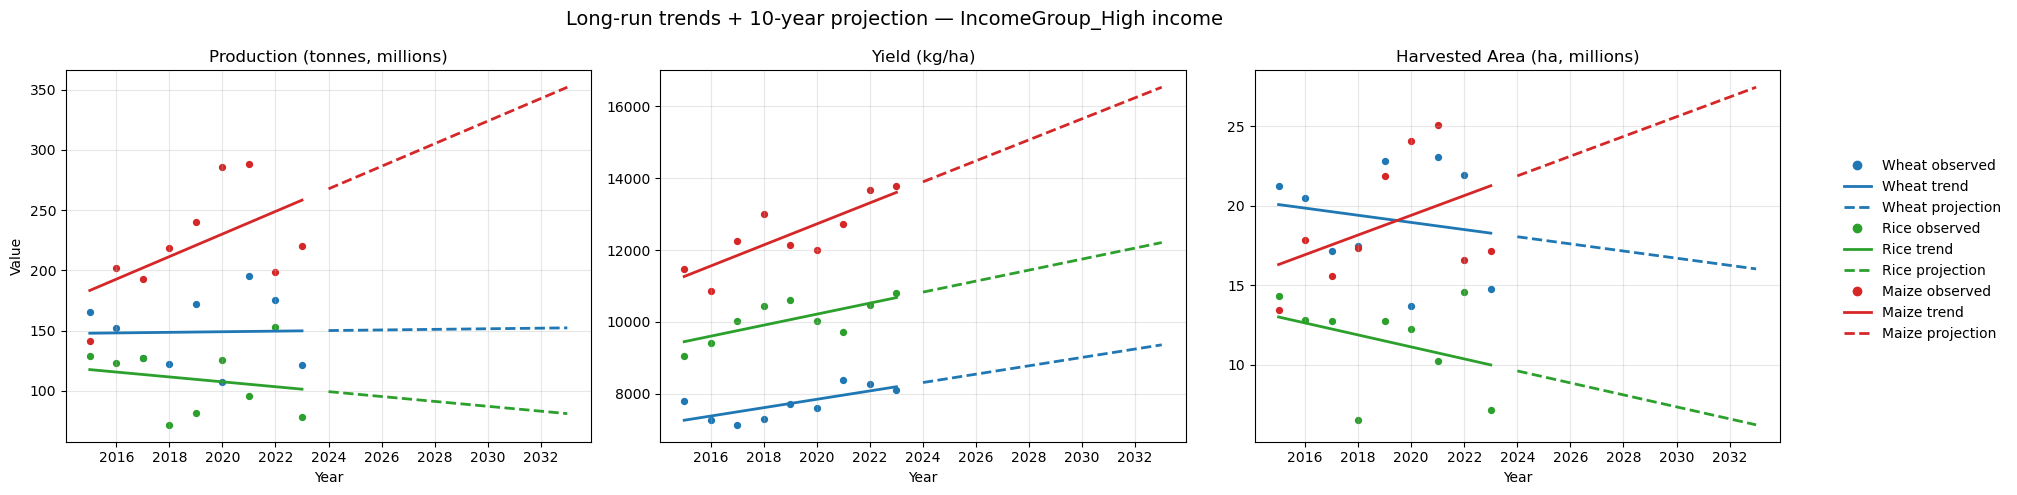

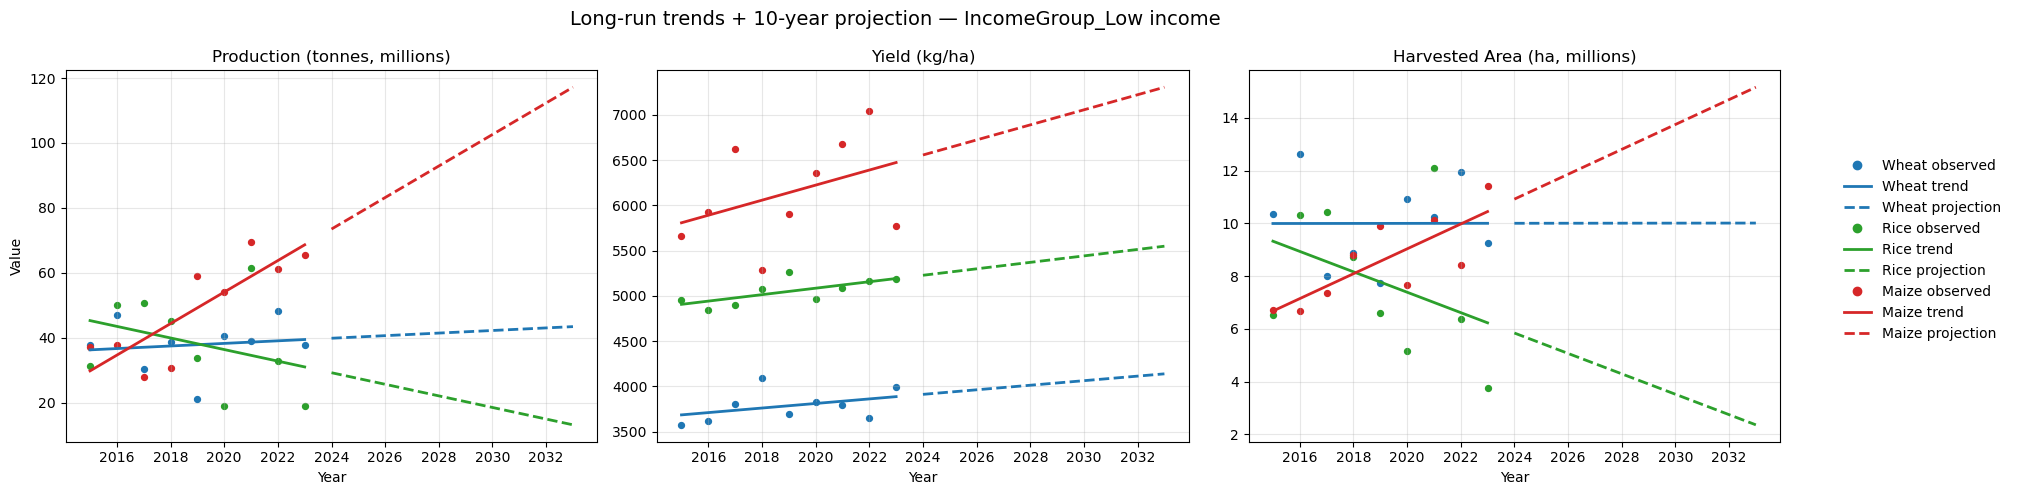

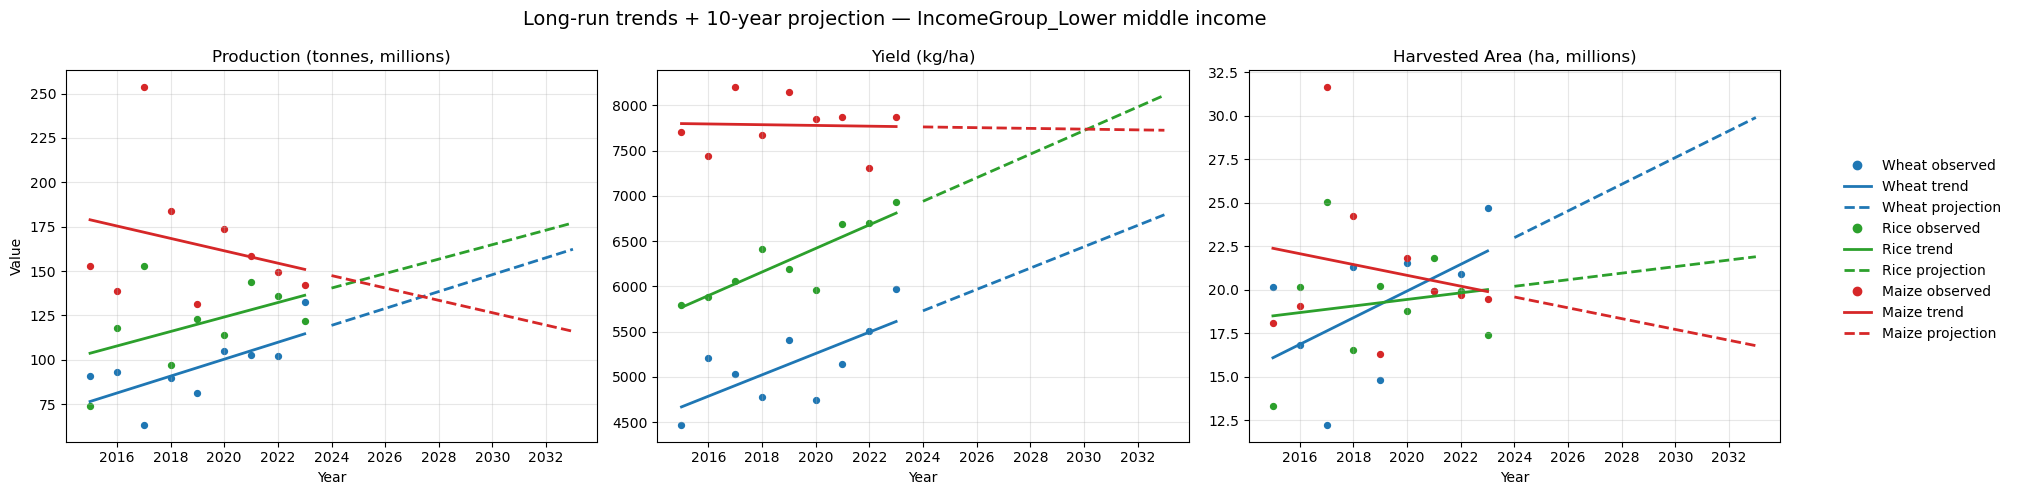

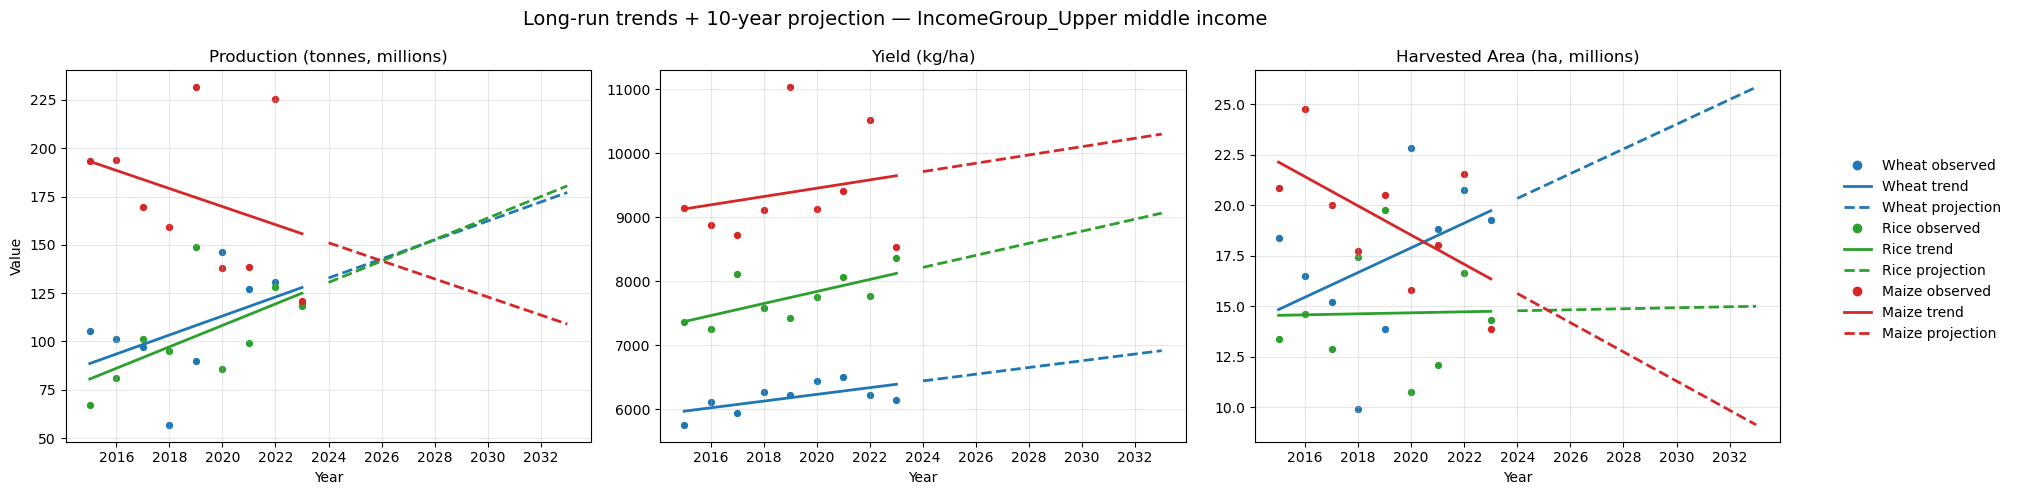

In [10]:
# trends by development stage (income group)
for ig in sorted(df["income_group"].unique()):
    sub = df[df["income_group"] == ig].copy()
    plot_part1_for_geo(sub, f"IncomeGroup_{ig}")

## AI Disclosure:

During the completion of this Research Question, Artificial Intelligence (ChatGPT) was used to assist with coding structure, debugging, and syntax clarification. ChatGPT was helpful in refining function structure, ensuring proper implementation of trend projection functions, and improving the organization of reusable helper functions. Specifically, I used ChatGPT to confirm correct usage of numerical regression methods (e.g., NumPy least squares), structure the decomposition workflow, and streamline plotting routines across crops and regions. All econometric reasoning, model design, variable selection, interpretation of results, and written analysis are entirely my own.